# Attempting the Cloud Labels
-----------------------------------------
### Raw notebook as I played with the data. I just trained simple classifiers to the first moments of the pixel values found in the images. Just to see how they did.


### We first import useful libraries and the training labels

In [1]:
import matplotlib.pyplot as plt #importing some useful libraries
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
train_labels_tmp=pd.read_csv("train.csv")

In [2]:
np.where(train_labels_tmp.values[:][1]=='') #all images have labels. Lets see what they are.

(array([], dtype=int64),)

### Finding the unique labels and splitting them into two sets: Cloud Labels and Forest Labels. We focus on the cloud labelling first.

In [3]:
labels=[]
for i in range(len(train_labels_tmp.values)):
    labels=np.unique(np.append(labels,train_labels_tmp.values[i][1].split())) 
cloud_labels=np.array([labels[5],labels[6],labels[10],labels[11]])
forest_labels=np.array(list(set(labels)-set(cloud_labels)))
print(cloud_labels)
print(forest_labels)

['clear' 'cloudy' 'haze' 'partly_cloudy']
['cultivation' 'artisinal_mine' 'agriculture' 'habitation'
 'conventional_mine' 'selective_logging' 'slash_burn' 'primary' 'water'
 'blooming' 'blow_down' 'road' 'bare_ground']


### Let us turn these labels into numbers and then into vectors which can be used as onevsall inputs.

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

def cloud2num(x):
    l=np.array(x.split())
    for i in range(len(cloud_labels)):
        if(len(l[l==cloud_labels[i]])>0):
            return [i]
def forest2num(x):
    l=np.array(x.split())
    labels=[]
    for i in range(len(forest_labels)):
        if(len(l[l==forest_labels[i]])>0):
            labels.append(i)
    if(len(labels)>0): return labels
    return [len(forest_labels)] #If no labels are present, (i.e. only "cloudy" photo)

train_labels_cloud=[cloud2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_cloud=np.array(train_labels_cloud).ravel()
#train_labels_cloud=MultiLabelBinarizer().fit_transform(train_labels_cloud) #turns the integers into vectors
train_labels_forest=[forest2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_forest=np.array(train_labels_forest).ravel()
#train_labels_forest=MultiLabelBinarizer().fit_transform(train_labels_forest) #turns the integers into vectors


### We should now have two vectorized training labels: forest and cloud. The image *i* will then have labels *train_labels_cloud[i]* and *train_labels_forest[i]*. 

------
## Cloud Data/Labels
-------
### Lets look at the distribution,

In [5]:
np.mean(train_labels_cloud,axis=0)

0.72810593147063907

### Mostly clear label. Haze and cloudy are each about 6% of the data.

### Lets try something very easy, namely simply looking at the moments of our images.

In [6]:
from scipy.stats import moment
from skimage import measure as ms
def preprocess(img):
    img=np.reshape((plt.imread(img)-128)/128,((256*256,4)))
    mean=np.mean(img,axis=0)
    variance=np.std(img,axis=0)
    kurtosis=moment(img,moment=3,axis=0)
    skew=moment(img,moment=4,axis=0)
#    blobs=ms.find_contours(img,0.99)    
    return np.concatenate((mean,variance,kurtosis,skew),axis=0)
def extractfeatures(numarray):
    features=[]
    for i in numarray:
        features.append(preprocess('train-jpg/train_'+str(i)+'.jpg'))
    return np.array(features)

In [7]:
trainNum=2000
testNum=2000
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum

features_train=extractfeatures(numarray_train)
features_test=extractfeatures(numarray_test)


In [8]:

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

LR=LogisticRegression()
LR.fit(features_train,train_labels_cloud[:trainNum])
trainscore=LR.score(features_train,train_labels_cloud[:trainNum])
testscore=LR.score(features_test,train_labels_cloud[trainNum:trainNum+testNum])


lda=LDA()
lda.fit(features_train,train_labels_cloud[:trainNum])
trainscorelda=lda.score(features_train,train_labels_cloud[:trainNum])
testscorelda=lda.score(features_test,train_labels_cloud[trainNum:trainNum+testNum])

rfc=RFC()
rfc.fit(features_train,train_labels_cloud[:trainNum])
trainscorerfc=rfc.score(features_train,train_labels_cloud[:trainNum])
testscorerfc=rfc.score(features_test,train_labels_cloud[trainNum:trainNum+testNum])

gbc=GBC()
gbc.fit(features_train,train_labels_cloud[:trainNum])
trainscoregbc=gbc.score(features_train,train_labels_cloud[:trainNum])
testscoregbc=gbc.score(features_test,train_labels_cloud[trainNum:trainNum+testNum])

print('The LogReg training score is: ', trainscore)
print('The LogReg test score is:', testscore)
print('The LDA training score is: ', trainscorelda)
print('The LDA test score is:', testscorelda)
print('The RFC training score is: ', trainscorerfc)
print('The RFC test score is:', testscorerfc)
print('The GBC training score is: ', trainscoregbc)
print('The GBC test score is:', testscoregbc)

/home/phrenk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The LogReg training score is:  0.7585
The LogReg test score is: 0.761
The LDA training score is:  0.7845
The LDA test score is: 0.789
The RFC training score is:  0.991
The RFC test score is: 0.8185
The GBC training score is:  0.954
The GBC test score is: 0.8275


### Simple linear analysis can't do very well with the given features. Either go to more complex models such as RFC, or get better features. I am a bit surprised by the terrible performance here. Let us see what we are getting wrong with LogReg.

### Below shows the following plot: we choose the three features that have largest coefficients in the model that classifies if the sky is clear or not. These are the features that should dominate the decision. We can see that there is a lot of overlap (looking at the histograms, most of the purple points lie on top of the blue ones). 

In [9]:
maxcoeff=[np.argsort(LR.coef_[i])[:3] for i in range(len(LR.coef_))]
maxcoeff

[array([6, 0, 5]), array([1, 2, 4]), array([4, 1, 5]), array([ 3, 13, 14])]

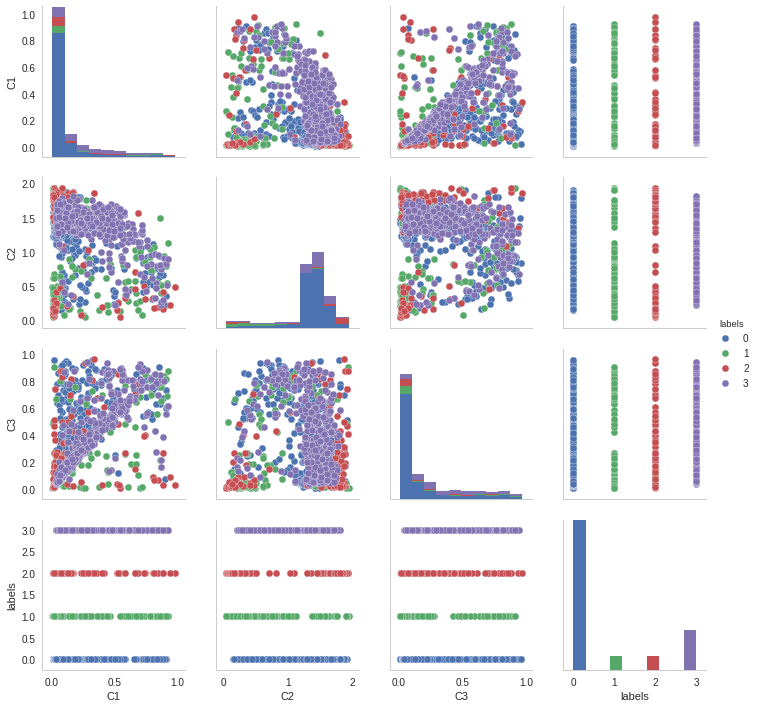

In [10]:
sns.set_style("whitegrid", {'axes.grid' : False})

df=pd.DataFrame({"C1": features_train[:,6],"C2": features_train[:,0],"C3": features_train[:,5],"labels":train_labels_cloud[:trainNum]})
sns.pairplot(df,hue="labels")

### Let us take a look at the confusion matrix.

/home/phrenk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/phrenk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


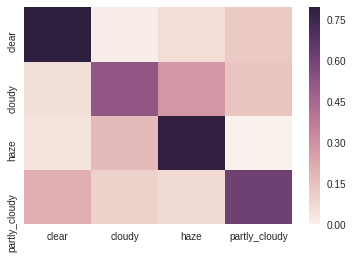

In [11]:
from sklearn.metrics import confusion_matrix as CM

Confmatrix=CM(LR.predict(features_test),train_labels_cloud[trainNum:trainNum+testNum])
ConfmatrixRescaled=[Confmatrix[i]/np.sum(Confmatrix,axis=1)[i] for i in range(4)]
g=sns.heatmap(ConfmatrixRescaled,xticklabels=cloud_labels,yticklabels=cloud_labels)


### The classifier is able to predict *clear* and *haze* the most accurately, but it is all over the place. The worse seems to be differentiating between *cloudy* and *haze* when a cloudy image is given. Lets look at misclassified pictures I guess

There are 478 misclassified test cases.
True Label: clear Predicted: partly_cloudy


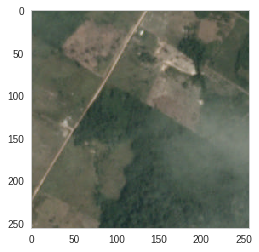

In [12]:
BadClass=np.where(LR.predict(features_test)!=train_labels_cloud[trainNum:trainNum+testNum])[0]
BadPred=LR.predict(features_test)[BadClass]
print("There are "+str(len(BadClass))+" misclassified test cases.")
def testimage(prednum):
    imgnum=BadClass[prednum]+trainNum
    print('True Label: '+cloud_labels[BadPred[prednum]]+' Predicted: '+cloud_labels[train_labels_cloud[imgnum]])
    plt.imshow(plt.imread('train-jpg/train_'+str(imgnum)+'.jpg'))
testimage(20)

True Label: clear Predicted: haze


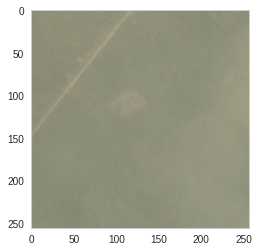

In [13]:
testimage(150)

True Label: clear Predicted: partly_cloudy


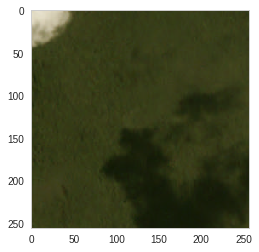

In [14]:
testimage(35)

True Label: partly_cloudy Predicted: clear


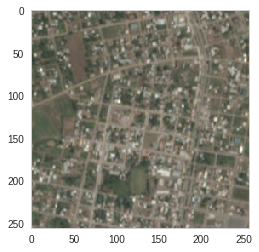

In [15]:
testimage(50)

### Test if for yourself... but I tend to agree with the classifier on these random choices I've just tried. There seems to be a lot of mislabeled images? Here's one (argument = 300) that I can agree was wrong:

True Label: partly_cloudy Predicted: clear


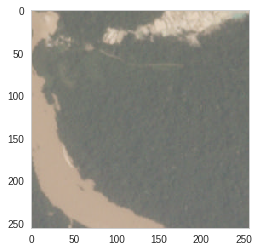

In [16]:
testimage(300)

True Label: partly_cloudy Predicted: cloudy


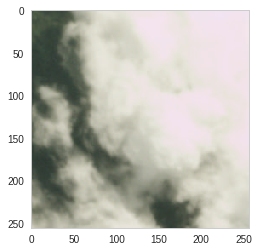

In [17]:
testimage(350)

True Label: clear Predicted: partly_cloudy


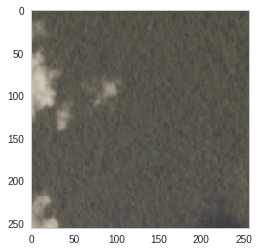

In [18]:
testimage(370)

### There is a level of subjectivity that comes into play when determining if something is partly_cloudy.